# CIFAR10 Classification with Data-efficient image Transformers(DeiT)

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

from torchsummary import summary

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
BATCH_SIZE = 32
LR = 5e-5
NUM_EPOCHES = 25

## Preprocessing

In [5]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

In [6]:
trainset = datasets.CIFAR10('../data/CIFAR10/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.CIFAR10('../data/CIFAR10/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Pre-training Teacher Model

In [7]:
# https://github.com/UdbhavPrasad072300/Transformer-Implementations/blob/main/pre-train/VGG16_CIFAR10.ipynb
teacher_model = torch.load("../trained_models/vgg16_cifar10.pth")

In [8]:
teacher_model.preprocess_flag = False
print(teacher_model.preprocess_flag)

False


## DeiT

In [9]:
from transformer_package.models.transformer import DeiT

In [10]:
image_size = 32
channel_size = 3
patch_size = 4
embed_size = 512
num_heads = 8
classes = 10
num_layers = 4
hidden_size = 512
dropout = 0.2

model = DeiT(image_size=image_size, 
             channel_size=channel_size, 
             patch_size=patch_size, 
             embed_size=embed_size, 
             num_heads=num_heads, 
             classes=classes, 
             num_layers=num_layers,
             hidden_size=hidden_size,
             teacher_model=teacher_model,
             dropout=dropout
            ).to(device)
model

DeiT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (embeddings): Linear(in_features=48, out_features=512, bias=True)
  (teacher_model): VGG16_classifier(
    (vgg16): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inpla

In [11]:
for img, label in trainloader:
    img = img.to(device)
    label = label.to(device)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out, teacher_out = model(img)
    
    print("Student Output Dimensions: {}".format(out.size()))
    print("Teacher Output Dimensions: {}".format(teacher_out.size()))
    break

Input Image Dimensions: torch.Size([32, 3, 32, 32])
Label Dimensions: torch.Size([32])
----------------------------------------------------------------------------------------------------
Student Output Dimensions: torch.Size([32, 10])
Teacher Output Dimensions: torch.Size([32, 10])


## Training with Hard Label Distillation

In [12]:
from transformer_package.loss_functions.loss import Hard_Distillation_Loss

In [13]:
criterion = Hard_Distillation_Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

In [14]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        
        preds, teacher_preds = model(img)
        
        loss = criterion(teacher_preds, preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 1644.12019843
       Train Accuracy%:  32.28 == 16140 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 1412.12571043
       Train Accuracy%:  43.754 == 21877 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 1342.61206454
       Train Accuracy%:  46.948 == 23474 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 1295.64139086
       Train Accuracy%:  49.306 == 24653 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 1259.07025161
       Train Accuracy%:  51.146 == 25573 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch:

## Test

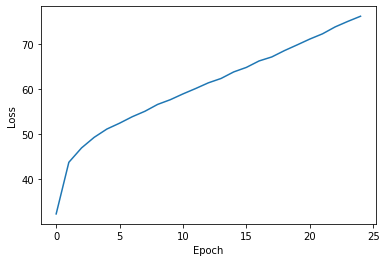

In [15]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

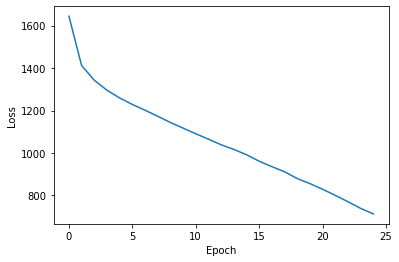

In [16]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
    
        preds, _ = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  61.55 == 6155 / 10000
